In [12]:
import pandas as pd
import torch

from torch.utils.data import Dataset

# Define custom dataset to load sequences
class EEGDataset(Dataset):
    def __init__(
        self,
        target_label: str,
        pandas_df: pd.DataFrame | None = None,
        csv_files: list[str] | None = None,
        sequence_length: int = 20,
        sequence_overlap: float = 0.0,
        features: list[str] | None = None, 
    ) -> None:
        if csv_files and pandas_df:
            raise ValueError('pandas_df or csv_file should be pased but NOT both.')
        if csv_files is None and pandas_df is None:
            raise ValueError('panas_df or csv_file MUST be passed.')
        if csv_files is not None and len(csv_files) < 1:
            raise ValueError('A minimum of 1 csv file MUST be passed.')
        if csv_files is not None:
            # Load and format the csv dataset
            df_list = []
            for file in csv_files:
                df = pd.read_csv(file)
                df = df.sort_values(by=df.columns[0])
                df = df.drop(df.columns[0], axis=1)
                df_list.append(df)
            df = pd.concat(df_list)  
            self.eeg_data = df
            del df

        if pandas_df is not None:
            self.eeg_data = pandas_df
            self.eeg_data = self.eeg_data.reset_index(drop=True)

        self.sequence_overlap = sequence_overlap
        self.target_label = target_label
        self.features = features

        if self.features is None:
            self.features = list(self.eeg_data.columns)
            self.features.remove(target_label)

        self.sequence_length = sequence_length

    def __len__(self) -> int:
        overlap = self.sequence_overlap if self.sequence_overlap > 0 else 1
        return int((len(self.eeg_data) - self.sequence_length) / (self.sequence_length * overlap))
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:

        index = int(index*self.sequence_length*self.sequence_overlap + self.sequence_length)
        seq_start_idx = index - self.sequence_length

        X = torch.tensor(self.eeg_data[self.features][seq_start_idx:index].values).type(torch.FloatTensor)
        y = torch.tensor(self.eeg_data[self.target_label][index]).type(torch.LongTensor)
        return X, y
    
    def split(self, split_ratio: float = 0.8) -> tuple:
        split_idx = int(len(self.eeg_data) * split_ratio)
        train_ds = EEGDataset(
            target_label=self.target_label,
            pandas_df=self.eeg_data[:split_idx],
            sequence_length=self.sequence_length,
            sequence_overlap=self.sequence_overlap,
            features=self.features,
        )
        valid_ds = EEGDataset(
            target_label=self.target_label,
            pandas_df=self.eeg_data[split_idx+1:],
            sequence_length=self.sequence_length,
            sequence_overlap=self.sequence_overlap,
            features=self.features,
        )
        
        return train_ds, valid_ds  

In [13]:
# Load dataset
sequence_length = 40
sequence_overlap = 0.6
target_label = 'Marker'
ds: EEGDataset = EEGDataset(
    csv_files=[
        '../datasets/csv/HaLT-SubjectA-160223-6St-LRHandLegTongue_experiment_0.csv',
        '../datasets/csv/HaLT-SubjectA-160223-6St-LRHandLegTongue_experiment_1.csv',
        '../datasets/csv/HaLT-SubjectA-160223-6St-LRHandLegTongue_experiment_2.csv',
        '../datasets/csv/HaLT-SubjectA-160308-6St-LRHandLegTongue_experiment_0.csv',
        '../datasets/csv/HaLT-SubjectA-160308-6St-LRHandLegTongue_experiment_1.csv',
        '../datasets/csv/HaLT-SubjectA-160310-6St-LRHandLegTongue_experiment_0.csv',
        '../datasets/csv/HaLT-SubjectA-160310-6St-LRHandLegTongue_experiment_1.csv',
        '../datasets/csv/HaLT-SubjectB-160218-6St-LRHandLegTongue_experiment_0.csv',
        '../datasets/csv/HaLT-SubjectB-160218-6St-LRHandLegTongue_experiment_1.csv',
        '../datasets/csv/HaLT-SubjectB-160218-6St-LRHandLegTongue_experiment_2.csv',
        '../datasets/csv/HaLT-SubjectB-160225-6St-LRHandLegTongue_experiment_0.csv',
        '../datasets/csv/HaLT-SubjectB-160225-6St-LRHandLegTongue_experiment_1.csv',
        '../datasets/csv/HaLT-SubjectB-160225-6St-LRHandLegTongue_experiment_2.csv',
        '../datasets/csv/HaLT-SubjectB-160229-6St-LRHandLegTongue_experiment_0.csv',
        '../datasets/csv/HaLT-SubjectB-160229-6St-LRHandLegTongue_experiment_1.csv',
        '../datasets/csv/HaLT-SubjectB-160229-6St-LRHandLegTongue_experiment_2.csv',
    ],
    target_label=target_label,
    sequence_length=sequence_length,
    sequence_overlap=sequence_overlap,
)

train_ds, valid_ds = ds.split()

del ds

In [14]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 740

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=3)
validation_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=2)

print(len(train_loader.dataset.eeg_data))
print(train_loader.dataset.__len__())
train_loader.dataset.eeg_data.head()

577629
24066


,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5,Marker
0,5.96,9.27,-2.47,1.62,0.37,-0.31,-1.97,-0.18,-1.64,-0.18,...,5.36,2.56,3.60,2.33,0.46,0.05,-0.90,0.60,0.10,0
1,-0.56,10.45,1.10,1.87,1.37,-1.32,0.79,1.26,0.60,1.51,...,-0.59,0.25,-1.22,1.91,-0.54,4.41,4.49,2.98,-0.03,0
2,-3.60,9.30,-1.98,5.98,-1.81,2.29,-5.11,-0.82,-6.07,-0.80,...,6.84,-5.01,2.26,-5.23,-1.18,2.42,1.40,-0.97,-0.00,0
3,-8.21,6.74,-3.58,0.48,-0.41,0.09,-0.43,-0.95,-1.10,-0.58,...,2.36,-3.13,0.71,-0.90,-1.48,-0.77,0.27,-0.30,-0.39,0
4,-2.05,12.03,0.54,-3.85,2.16,-3.58,0.93,-0.71,1.06,-0.66,...,0.28,2.53,-3.02,1.89,-1.27,-1.71,-0.82,-1.59,-0.31,0


In [16]:
validation_loader.dataset.eeg_data.head()

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5,Marker
0,-0.15,-4.65,1.51,-5.03,2.29,-3.23,0.34,-2.14,-2.47,-2.06,...,-9.46,-1.02,-5.16,-1.53,-3.29,0.11,3.62,-0.83,-0.57,1
1,3.33,-4.74,3.63,-4.66,3.71,-4.24,1.86,-2.28,-2.42,-1.17,...,-11.20,1.85,-7.06,0.32,-3.63,3.03,3.53,-0.07,0.28,1
2,-0.46,-5.48,3.67,-7.89,4.84,-5.53,2.87,-1.36,-1.54,2.27,...,-15.26,3.32,-4.14,0.99,-0.39,-0.84,1.06,-0.91,-0.67,1
3,2.98,-5.83,6.46,-8.59,6.88,-6.55,4.58,-0.15,0.87,4.90,...,-10.99,7.78,-7.70,4.37,1.35,2.45,0.55,-0.22,0.18,1
4,0.12,-6.76,5.02,-9.68,6.36,-6.96,3.15,-1.44,-0.18,3.59,...,-12.59,16.19,-8.17,3.16,-0.65,-0.94,-1.56,-1.82,-0.24,1


In [17]:
# Train NN
import datetime

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    total_start = datetime.datetime.now()
    correct, train_loss = 0, 0
     
    size = dataloader.dataset.__len__()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.unsqueeze(1).to(device), y.to(device)

        optimizer.zero_grad()

        # Compute prediction and loss
        pred, _ = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += torch.eq(torch.argmax(pred, dim=1), y).type(torch.float).sum().item()
        train_loss += loss.item()
        
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print(f'Training time: {(datetime.datetime.now() - total_start).total_seconds()}')
    correct /= size
    return train_loss / batch, correct


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = dataloader.dataset.__len__()
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.unsqueeze(1).to(device), y.to(device)
            pred, _ = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += torch.eq(torch.argmax(pred, dim=1), y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

    return test_loss, correct


In [18]:
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import CfC

class LiquidBlock(nn.Module):
    def __init__(self, units=20, out_features=10, in_features=5):
        super().__init__()
        wiring = AutoNCP(units, out_features)
        self.units = units
        self.liquid = CfC(in_features, wiring, return_sequences=True, batch_first=True)

    def forward(self, x, state=None):
        x, hx = self.liquid.forward(input=x, hx=state)
        return x, hx

In [19]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, out_features, dropout):
        super().__init__()
        self.cnn = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Conv layer 2
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Conv layer 3
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Flatten
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.LazyLinear(out_features=out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout1d(p=dropout),
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.linear(x)

        return x


In [20]:
class LiquidEEG(nn.Module):
    def __init__(self, liquid_units=20, num_classes=10, in_features=5, dropout=0.0):
        super().__init__()
        self.conv_block = ConvolutionalBlock(in_features, dropout=dropout)
        self.liquid_block = LiquidBlock(units=liquid_units, out_features=num_classes, in_features=in_features)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, state=None):
        x = self.conv_block(x)
        x, hx = self.liquid_block.forward(x, state)
        return self.softmax(x), hx

In [21]:
import numpy as np

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

loss_fn = nn.CrossEntropyLoss()
classes = np.unique(train_ds.eeg_data['Marker'])

learning_rate = 1e-3
model_units = 225
decay_rate = 0.96
dropout = 0.2

model = LiquidEEG(liquid_units=model_units, num_classes=len(classes), in_features=len(train_ds.features), dropout=dropout).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate, verbose=True)

epochs = 15
history = []

Adjusting learning rate of group 0 to 1.0000e-03.


/home/chema/Documents/MasterIA/TFM/code/liquid-eeg/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(validation_loader, model, loss_fn)
    lr_scheduler.step()
    epoch = {'val': {'loss': test_loss, 'acc': test_acc}, 'train': {'loss': train_loss, 'acc': train_acc}}
    history.append(epoch)

print("Done!")

Epoch 1
-------------------------------
loss: 1.945651  [  520/24066]
Training time: 372.709626
Test Error: 
 Accuracy: 31.2%, Avg loss: 1.872305

Adjusting learning rate of group 0 to 9.6000e-04.
Epoch 2
-------------------------------
loss: 1.888380  [  520/24066]
Training time: 367.443403
Test Error: 
 Accuracy: 30.7%, Avg loss: 1.875232

Adjusting learning rate of group 0 to 9.2160e-04.
Epoch 3
-------------------------------
loss: 1.878396  [  520/24066]
Training time: 380.150725
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.871731

Adjusting learning rate of group 0 to 8.8474e-04.
Epoch 4
-------------------------------
loss: 1.872909  [  520/24066]
Training time: 385.657981
Test Error: 
 Accuracy: 37.7%, Avg loss: 1.839197

Adjusting learning rate of group 0 to 8.4935e-04.
Epoch 5
-------------------------------
loss: 1.860131  [  520/24066]
Training time: 366.241591
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.817261

Adjusting learning rate of group 0 to 8.1537e-04.
Epoch 6
-------

In [ ]:
print(f'MODEL PARAMETERS: {count_parameters(model)}')

print(history)

import json

train_log = {
    'num_params': count_parameters(model),
    'decay_rate': decay_rate,
    'batch_size': BATCH_SIZE,
    'learning_rate': learning_rate,
    'units': model_units,
    'num_epochs': epochs,
    'sequence_length': sequence_length,
    'sequence_overlap': sequence_overlap,
    'dropout': dropout,
    'features': train_ds.features,
    'train_samples': train_ds.__len__(),
    'epochs': history,
}

log_name = f'../log/pytorch/history_{datetime.datetime.timestamp(datetime.datetime.now())}.json'

with open(log_name, 'w', encoding='utf-8') as f:
    json.dump(train_log, f, ensure_ascii=False, indent=4)



MODEL PARAMETERS: 239762
[{'val': {'loss': 1.9328490793704987, 'acc': 0.20352149145520457}, 'train': {'loss': 2.0823553459984914, 'acc': 0.17052658817440808}}, {'val': {'loss': 1.9271992146968842, 'acc': 0.20507509062661833}, 'train': {'loss': 2.0638777017593384, 'acc': 0.21309354379609263}}, {'val': {'loss': 1.9046472311019897, 'acc': 0.24961160020714657}, 'train': {'loss': 2.067403895514352, 'acc': 0.1914866088756631}}, {'val': {'loss': 1.8897427916526794, 'acc': 0.2791299844640083}, 'train': {'loss': 2.0350150806563243, 'acc': 0.25773062491913573}}, {'val': {'loss': 1.8891136348247528, 'acc': 0.27239772138788193}, 'train': {'loss': 2.0240087594304765, 'acc': 0.26859878380126795}}, {'val': {'loss': 1.8888115286827087, 'acc': 0.276540652511652}, 'train': {'loss': 2.022799551486969, 'acc': 0.271315823521801}}, {'val': {'loss': 1.881543129682541, 'acc': 0.28845157949249095}, 'train': {'loss': 2.0199916703360423, 'acc': 0.2836071936861172}}, {'val': {'loss': 1.8791546523571014, 'acc': 0.

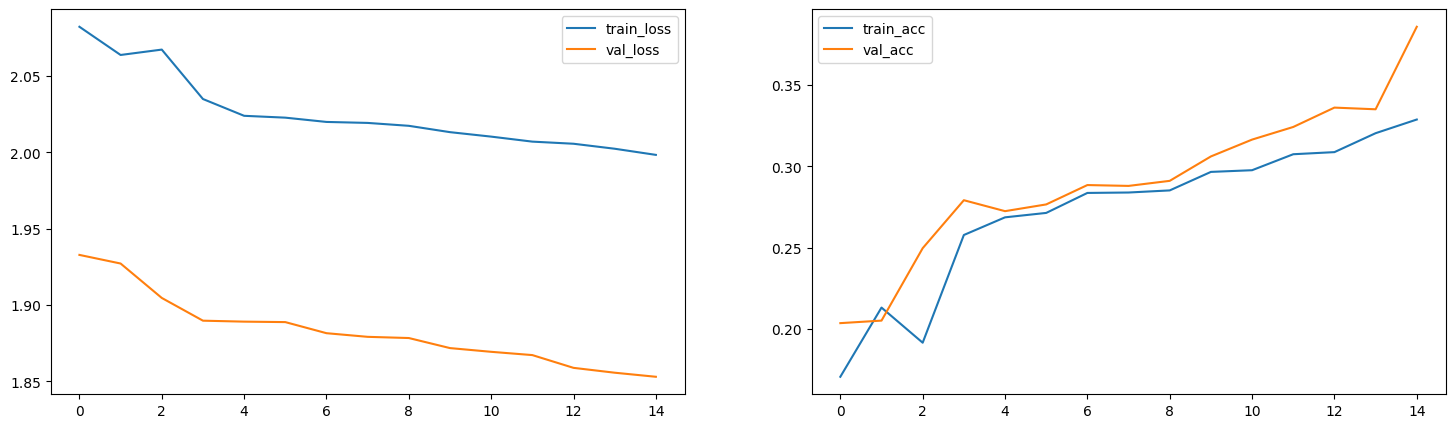

In [ ]:
import matplotlib.pyplot as plt

epoch_data = train_log.get('epochs', [])

val_loss = []
val_acc = []
train_loss = []
train_acc = []

for epoch_log in epoch_data:
    val_loss.append(epoch_log['val']['loss'])
    val_acc.append(epoch_log['val']['acc'])
    train_loss.append(epoch_log['train']['loss'])
    train_acc.append(epoch_log['train']['acc'])

num_epochs = range(len(epoch_data))

plt.figure(figsize=(18, 5))
plt.subplot(121)
plt.plot(num_epochs, train_loss, label='train_loss')
plt.plot(num_epochs, val_loss, label='val_loss')
plt.legend()
plt.subplot(122)
plt.plot(num_epochs, train_acc, label='train_acc')
plt.plot(num_epochs, val_acc, label='val_acc')
plt.legend()